# Titanic - Machine Learning from Disaster

此數據分析報告的目的是，基於泰坦尼克號乘客的性別和船艙等級等屬性，對倖存情況進行邏輯回歸分析，從而能利用得到的模型，對未知倖存情況的乘客，根據屬性預測是否從沉船事件中倖存。

欄位說明:

- PassengerId: 乘客編號
- Survived: 是否存活
- Pclass: 艙等
- Name: 姓名
- Sex: 性別
- Age: 年齡
- SibSp: 同行兄弟姊妹/配偶數
- Parch: 同行父母/子女數
- Ticket: 票號
- Fare: 船票價格
- Cabin: 客艙編號
- Embarked: 登船港口

## 載入函式庫與基本設定

In [711]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

## 載入資料

In [712]:
train_raw_df = pd.read_csv('../raw_data/train.csv')
train_raw_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 資料基本架構檢查

In [713]:
train_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [714]:
train_raw_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


根據前述結果分析如下

- Pclass: 無需調整，為 category
- Name: 無意義，刪除該欄位
- Sex: 需轉換類別，為 category
- Age: 有缺失值，需補值
- SibSp: 無需調整
- Parch: 無需調整
- Ticket: 無意義，刪除該欄位
- Fare: 無需調整
- Cabin: 有缺失值，但缺失值過多，刪除該欄位
- Embarked: 需轉換類別為 category，且有缺失值，需補值

## 資料前處理

In [715]:
train_processed_df = train_raw_df.copy()

In [716]:
def fill_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

    return df

In [717]:
def cast_data_type(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df['Pclass'] = df['Pclass'].astype('category')
    df['Sex'] = df['Sex'].astype('category')
    df['SibSp'] = df['SibSp'].astype('float64')
    df['Parch'] = df['Parch'].astype('float64')
    df['Embarked'] = df['Embarked'].astype('category')

    return df

In [718]:
train_processed_df = fill_missing_values(train_processed_df)
train_processed_df = cast_data_type(train_processed_df)

In [719]:
train_processed_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,NaN,S


In [720]:
train_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    float64 
 7   Parch        891 non-null    float64 
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     891 non-null    category
dtypes: category(3), float64(4), int64(2), object(3)
memory usage: 65.8+ KB


In [721]:
train_processed_df.describe()

,PassengerId,Survived,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,80.000000,8.000000,6.000000,512.329200


## 資料探索

### 倖存比

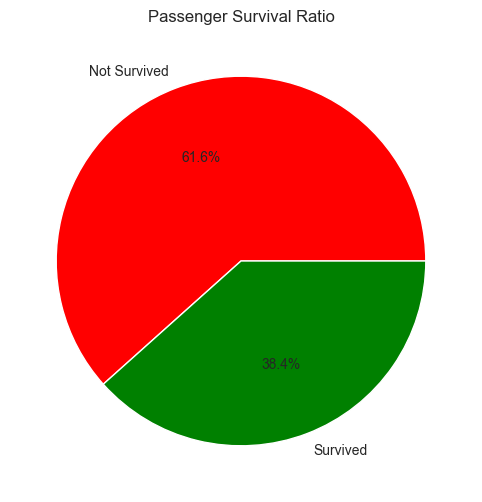

In [722]:
plt.figure(figsize=(8, 6))
survived_counts = train_processed_df['Survived'].value_counts()
plt.pie(survived_counts, labels=['Not Survived', 'Survived'], autopct='%1.1f%%', colors=['red', 'green'])
plt.title('Passenger Survival Ratio')
plt.show()

從以上圓餅圖來看，鐵達尼號罹難乘客多於倖存乘客，比例約 6:4

### 乘客年齡分佈

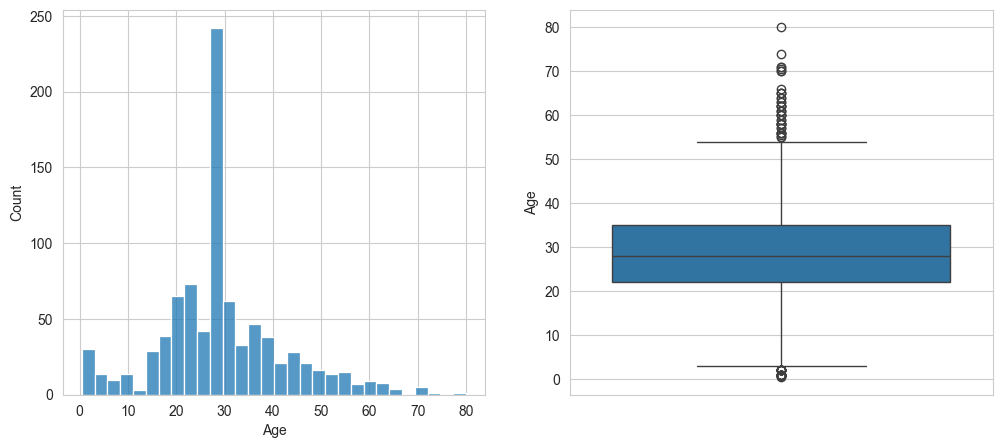

In [723]:
figure, axes = plt.subplots(1, 2, figsize=[12, 5])
sns.histplot(train_processed_df, x='Age', ax=axes[0])
sns.boxplot(train_processed_df, y='Age', ax=axes[1])
plt.show()

大多數乘客年齡位於 20 歲到 40 歲之間，但有不少老年乘客以及嬰兒

### 乘客年齡與是否倖存

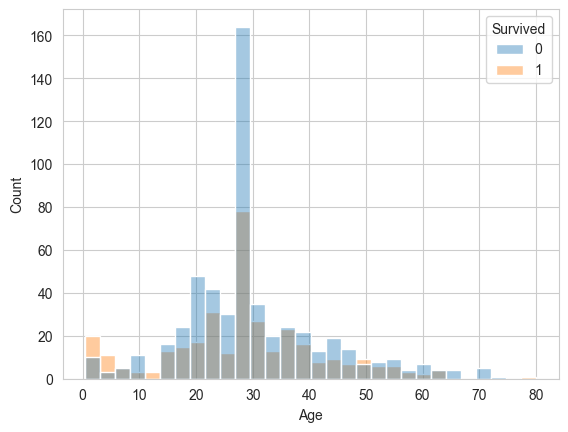

In [724]:
sns.histplot(train_processed_df, x='Age', hue='Survived', alpha=0.4)
plt.show()

從乘客年齡直方圖來看，只有嬰兒群倖存比例較高，絕大部分其餘年齡層都是罹難人數多於倖存人數

### 船票價格分佈

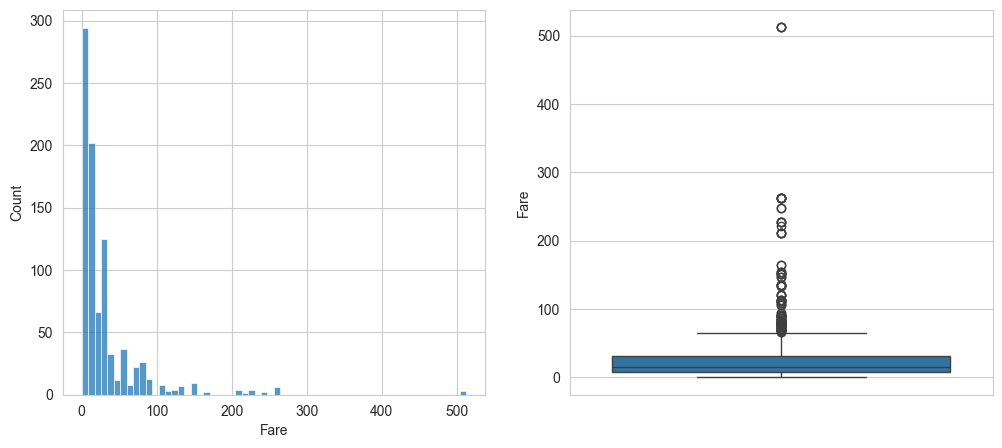

In [725]:
figure, axes = plt.subplots(1, 2, figsize=[12, 5])
sns.histplot(train_processed_df, x='Fare', ax=axes[0])
sns.boxplot(train_processed_df, y='Fare', ax=axes[1])
plt.show()

船票金額呈現右偏態分佈，顯示資料集中的大多數船票價格中等，但有一些票價很高的極端值，使得平均值被拉高

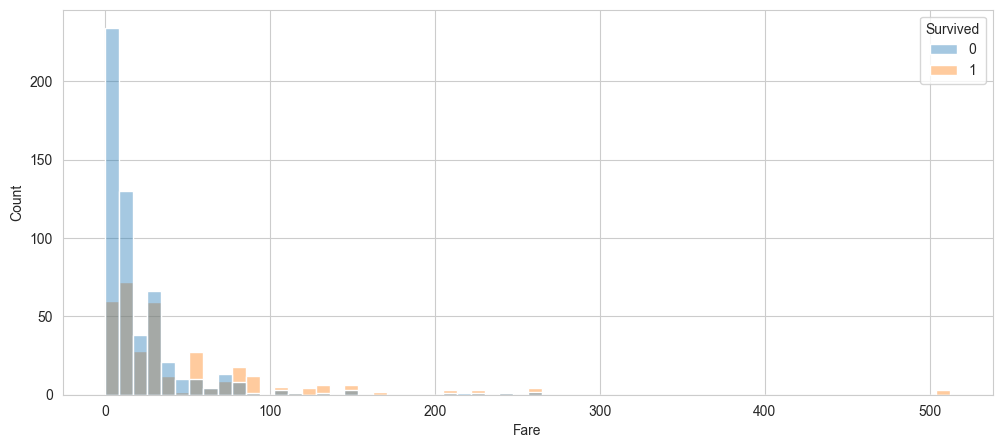

In [726]:
plt.subplots(1, 1, figsize=[12, 5])
sns.histplot(train_processed_df, x='Fare', hue='Survived', alpha=0.4)
plt.show()

### 船艙等級與是否倖存的關係

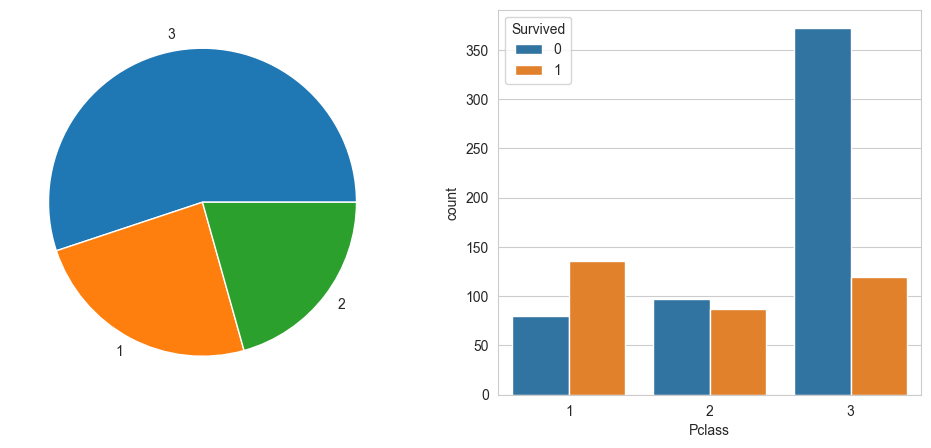

In [727]:
figure, axes = plt.subplots(1, 2, figsize=[12, 5])
pclass_count = train_processed_df['Pclass'].value_counts()
pclass_label = pclass_count.index
axes[0].pie(pclass_count, labels=pclass_label)
sns.countplot(train_processed_df, x='Pclass', hue='Survived', ax=axes[1])
plt.show()

從是否倖存與船艙等級之間的長條圖來看，船艙等級低的乘客中遇難比例更大，船艙等級高的乘客中倖存比例更大

### 性別與是否倖存的關係

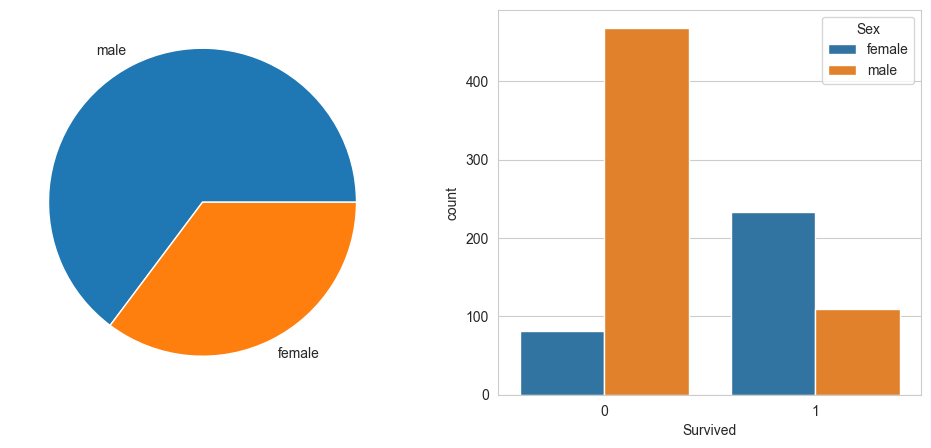

In [728]:
figure, axes = plt.subplots(1, 2, figsize=[12, 5])
sex_count = train_processed_df['Sex'].value_counts()
sex_label = sex_count.index
axes[0].pie(sex_count, labels=sex_label)
sns.countplot(train_processed_df, x='Survived', hue='Sex', ax=axes[1])
plt.show()

從是否倖存與性別之間的長條圖來看，男性乘客中遇難比例更大，女性乘客中倖存比例更大

### 登船港與是否倖存的關係

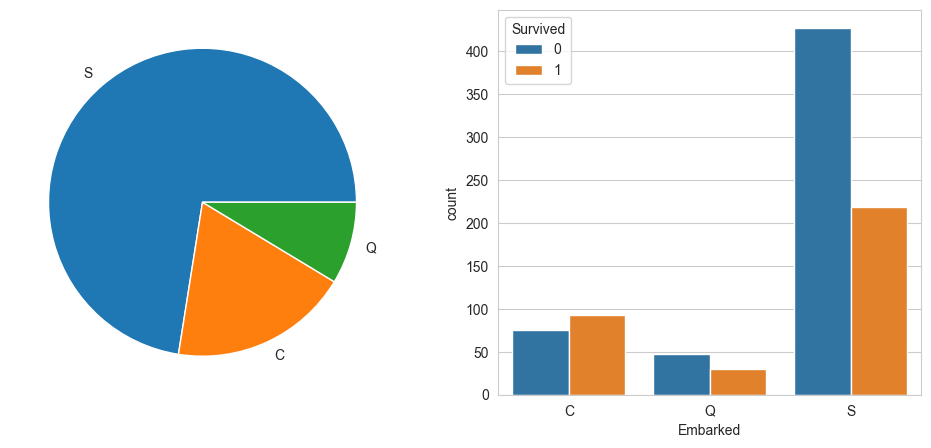

In [729]:
figure, axes = plt.subplots(1, 2, figsize=[12, 5])
embarked_count = train_processed_df['Embarked'].value_counts()
embarked_label = embarked_count.index
axes[0].pie(embarked_count, labels=embarked_label)
sns.countplot(train_processed_df, x='Embarked', hue='Survived', ax=axes[1])
plt.show()

從是否倖存與登船港之間的長條圖來看，瑟堡登船的乘客，倖存數量大於遇難數量，而皇后鎮和南安普敦則相反

### 家庭成員數與是否存活的關係

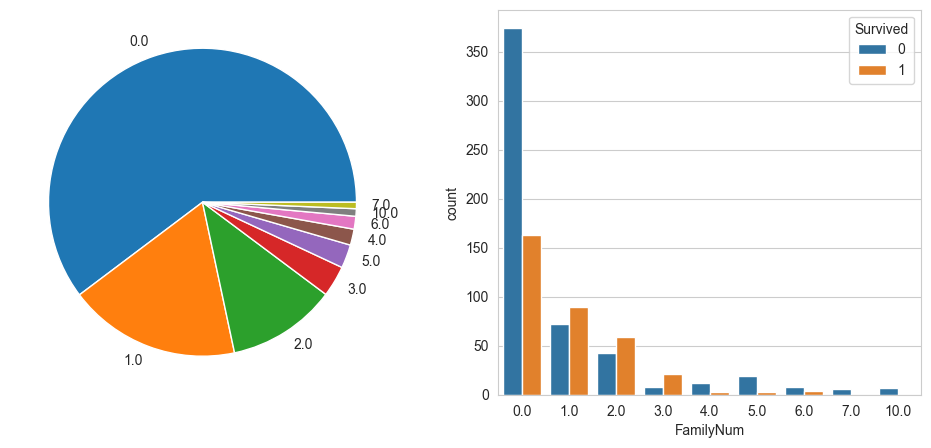

In [730]:
train_processed_df['FamilyNum'] = train_processed_df['SibSp'] + train_processed_df['Parch']

figure, axes = plt.subplots(1, 2, figsize=[12, 5])
familyNum_count = train_processed_df['FamilyNum'].value_counts()
familyNum_label = familyNum_count.index
axes[0].pie(familyNum_count, labels=familyNum_label)
sns.countplot(train_processed_df, x='FamilyNum', hue='Survived', ax=axes[1])
plt.show()

train_processed_df.drop(columns=['FamilyNum'], inplace=True)

從是否倖存與乘客家庭成員之間的長條圖來看，獨身的乘客中遇難的多於倖存的。從有攜帶家庭成員的乘客來看，家庭成員在 1～3 位之間的倖存人數超過遇難人數，但同乘家庭成員超過3位後，遇難的更多

## 特徵工程

In [731]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df['FamilySize'] = df['SibSp'] + df['Parch']

    return df

In [732]:
def drop_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    drop_columns = ['Name', 'Ticket', 'Cabin']
    df = df.drop(columns=drop_columns)

    return df

In [733]:
train_processed_df = create_features(train_processed_df)
train_processed_df = drop_features(train_processed_df)

In [734]:
train_processed_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize
0,1,0,3,male,22.0,1.0,0.0,7.2500,S,1.0
1,2,1,1,female,38.0,1.0,0.0,71.2833,C,1.0
2,3,1,3,female,26.0,0.0,0.0,7.9250,S,0.0
3,4,1,1,female,35.0,1.0,0.0,53.1000,S,1.0
4,5,0,3,male,35.0,0.0,0.0,8.0500,S,0.0


In [735]:
train_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    category
 3   Sex          891 non-null    category
 4   Age          891 non-null    float64 
 5   SibSp        891 non-null    float64 
 6   Parch        891 non-null    float64 
 7   Fare         891 non-null    float64 
 8   Embarked     891 non-null    category
 9   FamilySize   891 non-null    float64 
dtypes: category(3), float64(5), int64(2)
memory usage: 51.8 KB


In [736]:
train_processed_df.describe()

,PassengerId,Survived,Age,SibSp,Parch,Fare,FamilySize
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,29.361582,0.523008,0.381594,32.204208,0.904602
std,257.353842,0.486592,13.019697,1.102743,0.806057,49.693429,1.613459
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000
50%,446.000000,0.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,668.500000,1.000000,35.000000,1.000000,0.000000,31.000000,1.000000
max,891.000000,1.000000,80.000000,8.000000,6.000000,512.329200,10.000000


## 模型訓練

In [737]:
X = train_processed_df.drop(columns=['Survived', 'PassengerId'])
y = train_processed_df['Survived']

In [738]:
categorical_features = ['Pclass', 'Sex', 'Embarked']
numerical_features = ['Age', 'Fare', 'FamilySize']

categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', categorical_transformer, categorical_features),
    ('num', numerical_transformer, numerical_features)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [739]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
}

results = cross_validate(pipeline, X, y, cv=kf, scoring=scoring, return_train_score=True)

print("🔍 訓練集結果 (平均)")
print(f"✅ Accuracy: {results['train_accuracy'].mean():.4f}")
print(f"🎯 Precision: {results['train_precision'].mean():.4f}")
print(f"📢 Recall: {results['train_recall'].mean():.4f}")
print(f"📊 F1 Score: {results['train_f1'].mean():.4f}")
print(f"📈 ROC AUC: {results['train_roc_auc'].mean():.4f}")

print("🔍 測試集結果 (平均)")
print(f"✅ Accuracy: {results['test_accuracy'].mean():.4f}")
print(f"🎯 Precision: {results['test_precision'].mean():.4f}")
print(f"📢 Recall: {results['test_recall'].mean():.4f}")
print(f"📊 F1 Score: {results['test_f1'].mean():.4f}")
print(f"📈 ROC AUC: {results['test_roc_auc'].mean():.4f}")

🔍 訓練集結果 (平均)
✅ Accuracy: 0.8148
🎯 Precision: 0.7823
📢 Recall: 0.7170
📊 F1 Score: 0.7482
📈 ROC AUC: 0.8634
🔍 測試集結果 (平均)
✅ Accuracy: 0.8025
🎯 Precision: 0.7665
📢 Recall: 0.6916
📊 F1 Score: 0.7259
📈 ROC AUC: 0.8445


In [740]:
pipeline.fit(X, y)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [741]:
y_pred = pipeline.predict(X)
print("Accuracy:", accuracy_score(y, y_pred))
print("F1 Score:", f1_score(y, y_pred))
print("Precision:", precision_score(y, y_pred))
print("Recall:", recall_score(y, y_pred))

Accuracy: 0.8170594837261503
F1 Score: 0.7503828483920367
Precision: 0.7877813504823151
Recall: 0.716374269005848


## 預測

In [742]:
test_raw_df = pd.read_csv('../raw_data/test.csv')
test_raw_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [743]:
test_processed_df = test_raw_df.copy()
test_processed_df = fill_missing_values(test_processed_df)
test_processed_df = cast_data_type(test_processed_df)
test_processed_df = create_features(test_processed_df)
test_processed_df = drop_features(test_processed_df)

In [744]:
test_processed_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize
0,892,3,male,34.5,0.0,0.0,7.8292,Q,0.0
1,893,3,female,47.0,1.0,0.0,7.0000,S,1.0
2,894,2,male,62.0,0.0,0.0,9.6875,Q,0.0
3,895,3,male,27.0,0.0,0.0,8.6625,S,0.0
4,896,3,female,22.0,1.0,1.0,12.2875,S,2.0


In [745]:
X = test_processed_df.drop(columns=['PassengerId'])

In [746]:
y_pred = pipeline.predict(X)
submission_df = pd.DataFrame({'PassengerId': test_raw_df['PassengerId'], 'Survived': y_pred})
submission_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [747]:
submission_df.to_csv('submission.csv', index=False)